# COVID-19: Data Preprocessing and Analysis

In [46]:
import pandas as pd
import missingno as msno
import numpy as np

## Data

The data we will be working on are on local authority level (LAD) and contain demographic and social information based on the 2011 census survey but as well as most recent (2017-18) UK migration information, healthcare statistics, England and Wales deprivation index (IMD), Persona OAC, and COVID cases. A complete list and explanation of the data can be found at the [dataset repository](https://github.com/epidemic-research-team/datasets).

In [47]:
nomis_data = pd.read_excel("./Data/NOMIS/NOMIS Data 2011 Census.xlsx")

In [61]:
nomis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Columns: 227 entries, Local Authority District to Violent crime - hospital admissions for violence
dtypes: float64(78), int64(145), object(4)
memory usage: 617.3+ KB


In [62]:
nomis_data.dtypes

Local Authority District                                       object
LAD16CD                                                        object
Region                                                         object
Country                                                        object
Total                                                           int64
                                                               ...   
Smoking Prevalence in adults (18+) - current smokers (APS)    float64
Statutory homelessness                                        float64
Suicide rate                                                  float64
TB incidence (three year average)                             float64
Violent crime - hospital admissions for violence              float64
Length: 227, dtype: object

## Missing Values Processing

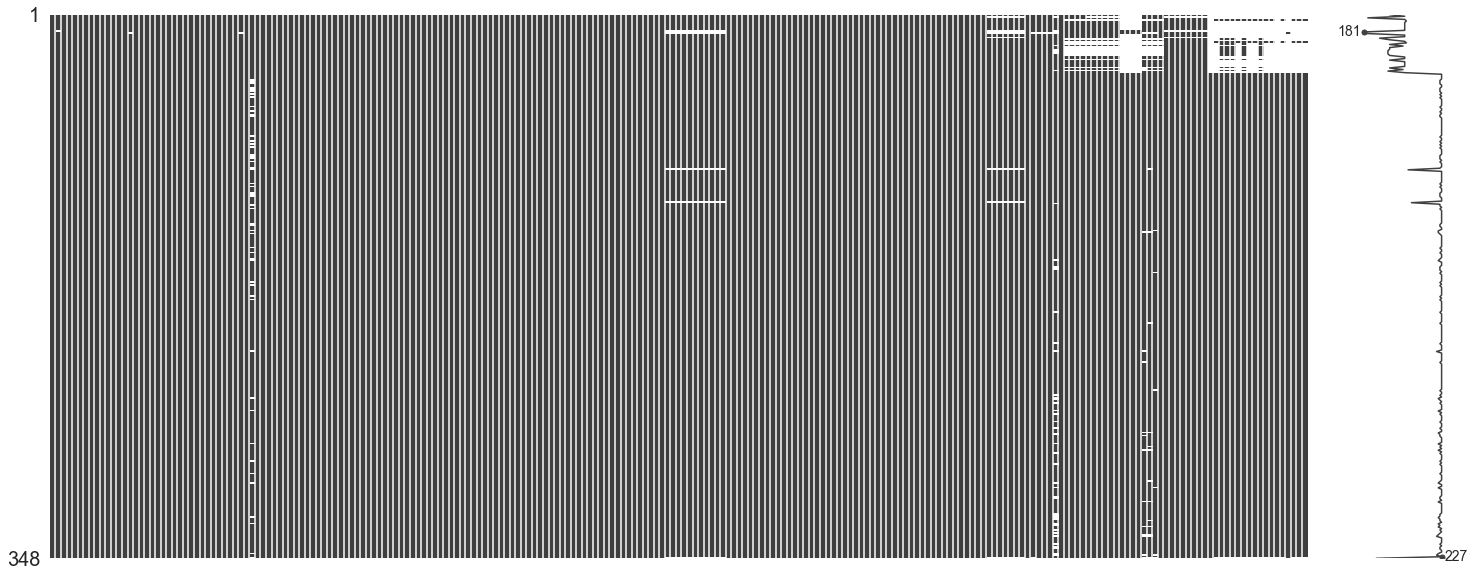

In [63]:
msno.matrix(nomis_data)

In [64]:
nomis_data.shape

(348, 227)

*(Figure 1)* From the matrix above, the dataset we have is very much complete. The majority of the variables do not have missing values. Though, we observe a large cluster of missing values in the last variables of the dataset. These variables are the IMD data and the NHS healthcare data. The reason that are missing is that in IMD, Wales does not publish IDACI and IDAOPI IMD scores (deprivation for children and seniors); also the data are based on new LAD areas (after 2017) that they differ from the 2015 that we use as a baseline; finally, the healthcare data contain information from Unitary Authorities, Metropolitan Districts, London Boroughs and Counties but not the Non-metropolitan Districts, so not the full LAD areas.

Instead of using a proxy score to fill the missing values we choose to drop these rows. The remaining $n=300$ rows are sufficient enough to perform robust statistical analysis on the dataset.

In [48]:
# We choose "Admission episodes for alcohol-related conditions (Narrow)" variable as a base to clear the rows from the missing values.
nomis_data = nomis_data[nomis_data.iloc[:, -17].notna()] 
# Then, we do a further cleaning based on "UK Cases" (COVID-19 cases, latest as of 08-May)
nomis_data = nomis_data[nomis_data.iloc[:, -18].notna()]

In [49]:
nomis_data.shape

(309, 227)

## Correlation Analysis on the Data

In [50]:
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

Below, we perform some standard statistical analysis on the processed data. 

Our aim is to have a finilised sample that can be used as an input to various statistical models.

In [51]:
# Before we normalise the data and fill the remaining missing values, we will save the LAD info on a seperate vector 
# in case we want to combine the area names with the normalised data later.
LAD = nomis_data["Local Authority District"]

X = nomis_data.select_dtypes(exclude=['object']).copy()
X.shape

(309, 223)

To fill the missing values we simply use the mean of each variable. We can change that later.

In [69]:
X.fillna((X.mean()), inplace=True)

Normalise the data using the existing scale function from Scikit-Learn

In [70]:
X_scaled = preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = X.columns.values

The data contain mainly demographic information in total numbers. Another extra step that we could do is to scale most of these attributes using as a denominator the total population from each LAD and then normalise the variables.

We use a pair plot to visualise the relationship amongst the variables.

[[]]

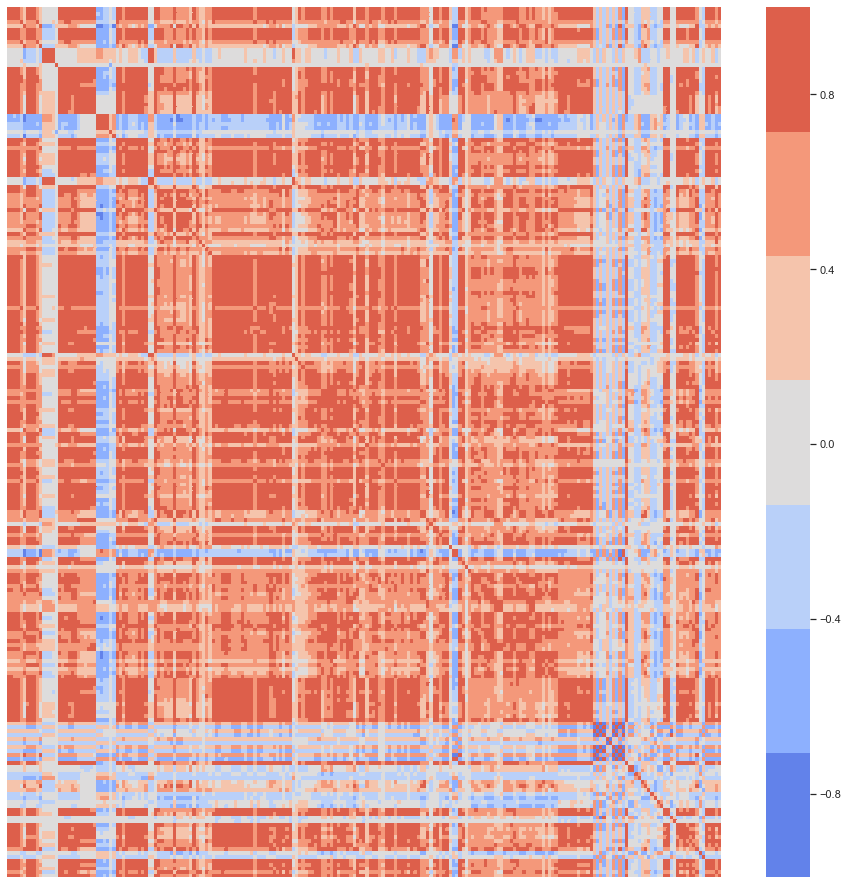

In [71]:
corr = X_scaled.corr()

pal = sns.color_palette("coolwarm", 7)
plt.figure(figsize=(16, 16))
g = sns.heatmap(corr, cmap=pal)
g.set(yticklabels=())
g.set(xticklabels=())

*(Figure 2)* The correlation matrix show that the majority of the variables are highly correlated; either negatively or positively. In fact, we can observe clusters of data across the whole sample. An explanation might be that because we use the raw data (even if we have normalised them) they are highly depedent on the population of a LAD area. So, a LAD of high population will have high density, many people working, more deaths etc. A remedy to this problem is to transform the data into a ratio form and then normalise them. 

Subsequently, we divide the data by the total population of each LAD (not all data, some of them cannot be divided; such as the average persons per household or the average age/income etc). We follow the same process as before, droping some rows with missing values and then filling the remaining with the average.

In [52]:
# Read the NOMIS dataframe but the variables this time (not all of them) are a ratio of the total population of each LAD
nomis_data = pd.read_csv("./Data/NOMIS/ratios NOMIS Data 2011 Census.csv")

In [53]:
# Keep the same rows/areas as before. Follow the same process.
nomis_data = nomis_data.loc[nomis_data["Local Authority District"].isin(LAD.values), :].copy()
LAD = nomis_data["Local Authority District"]
X = nomis_data.select_dtypes(exclude=['object']).copy()
X.shape

(309, 223)

In [54]:
X.fillna((X.mean()), inplace=True)
X_scaled = preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = X.columns.values

[[]]

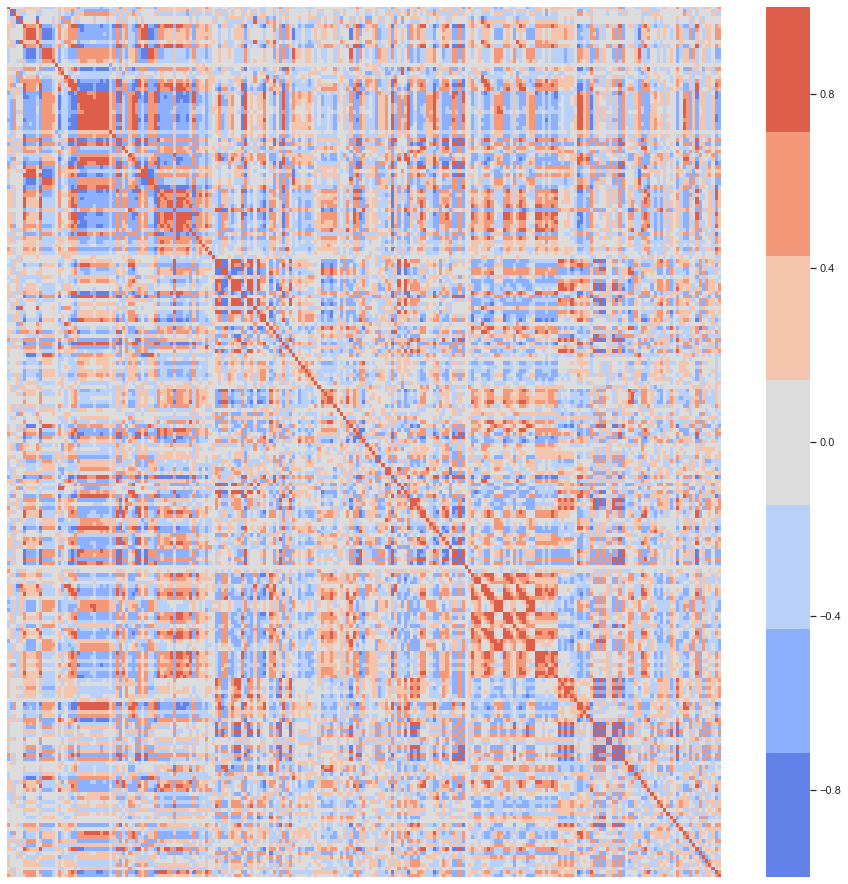

In [89]:
corr = X_scaled.corr()

pal = sns.color_palette("coolwarm", 7)
plt.figure(figsize=(16, 16))
g = sns.heatmap(corr, cmap=pal)
g.set(yticklabels=())
g.set(xticklabels=())

*(Figure 3)* The correlation matrix changed significantly now and by transforming the data we manage to de-correlate (up to a point) the previous correlation matrix. This time, positive and negative correlation clusters are more compact.

*(Table 1)* As a next step, we want to check the maximum score of standard daviation from the mean (since we have normalised the data) for each variable. That way we will ensure that when we evaluate the data later if these outliers play a major role in skewing the results.

In [12]:
print(pd.DataFrame(X_scaled.max().sort_values(ascending=False))[:20].to_string())

                                                                         0
N. America                                                       15.255458
DLA                                                              13.561046
Rural Density (number of persons per hectare)                    13.047410
North America and the Caribbean                                  13.046288
Oceania                                                          12.145413
I Accommodation and food service activities                      11.985803
R, S, T, U Other                                                 11.465827
Jewish                                                           11.368955
In a registered same-sex civil partnership                       11.189562
Shared ownership (part owned and part rented)                    11.080581
Bicycle                                                          10.799042
Hindu                                                            10.312158
O Public administration a

Another method to explore would be to visualise the relationship amongst the variables in a pair plot. But, because of the shear volume of the variables the pairplot is extremely slow.

## Statistical Analysis on the Data

In [55]:
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.linear_model import LassoCV
import statsmodels.api as sm

For the statistical analysis of the data we will use as variable of interest (dependent variable) the total number of COVID cases by LAD area.

In [56]:
y = X_scaled["UK Cases"]
X_scaled.drop('UK Cases', axis=1, inplace=True)

As a next step, we will apply dimensionality reduction methods on the dataset. 

These are
1. PCA; [Shlens, 2014](https://arxiv.org/pdf/1404.1100.pdf)
2. kernel PCA; [Bishop, 2013](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf)
3. Sparse PCA; [Zou et al., 2006](https://web.stanford.edu/~hastie/Papers/spc_jcgs.pdf)
4. LASSO; [Tibshirani, 1996](https://statweb.stanford.edu/~tibs/lasso/lasso.pdf)

The methods will allow us to compact the data and reduce the amount of projected information, therefore making the output more interpretable. 

### Principal Component Analysis

A first step in our analysis is to fit a PCA model on the data. Both, Jonathon Shlens ([Shlens, 2014](https://arxiv.org/pdf/1404.1100.pdf)) and David Barber ([Barber, 2012](http://web4.cs.ucl.ac.uk/staff/D.Barber/pmwiki/pmwiki.php?n=Brml.HomePage)) provide a thorough explanation of the mathematics behind PCA and matrix decomposition. 

In short, assume the NOMIS data as a data matrix $X$ with dimensions $n\times p$, with $n$ being the observations (in our case LAD authorities) and $p$ being the variables (demographics, health stastitics etc). PCA allows to map the original data $X$ into a lower dimensional space $Z$ that is constracted on principal components (PCs). 

In terms of matrix algebra, PCA decomposes a data matrix and ranks the eigenvalues from this decomposition. The eigenvalues show how stretched out the data are (the largest variance). The eigenvectors that are associated with the eigenvalues show the direction. The second eigenvactor will be orthogonal to the first one and again follows the direction of the second largest variance (eigenvalue).

The PCs are the new basis and are in fact a linear combination of the original basis $X$ that best express the variance in the dataset. 

$$
Z = XP
$$

with $P$ being a matrix of weights ($P \in \mathbb{R}^{p\times p}$) that stretch and rotate the original data $X$.

The PCs $Z$ have the characteristic that are orthogonal between them; Hence, completly independent. 

In general, the PCA has 6 requirements in order to generate meaningful results

1. There must be a linear relationship amongst variables of $X$.
2. It is recommended that the sample size be larger than the variables $n>p$ and to include more than 150 observations. The NOMIS dataset contains $n=309$ observations, more than the $p=215$ variables.
3. The variables should follow a Gaussian distribution. The reason is on number 4.
4. The mean and the variance of the dataset are considered sufficient statistics.
5. PCA is very sensitive to outliers. Subsequently, it is recommended to normalise the data and filter out any outliers. 
6. The PCs are orthogonal.

PCA can be solved using either eigendecomposition or SVD methods.

First, we use the covariance matrix $X^{T}X$ of the data $X$, because since we have normalised the data and they are normally distributed, $\sum_{i=1}^{n} x_{i} = 0$. The only statistic that we can use and contain all the information to describe Gaussian modeled data is the variance $\sigma$. 

We know that for any arbitary matrix $X$ the symmetric covariance matrix $X^{T}X$ with rank $r$ can be decomposed into a set of orthonormal eigenvectors $\hat{v}$ of size $(m\times 1)$ and eigenvalues $\lambda$ of the size $r$. 

$$
(X^{T}X)\hat{v}_{i} = \lambda_{i}\hat{v}_{i}
$$

with $i$ as the index for $r$. 

This, is translated to

$$
X\hat{v}_{i} = \sigma_{i}\hat{u}_{i}
$$

where, $\hat{u}$ a set of $(n\times 1)$ vectors defined as $hat{u}_{i} = \frac{X\hat{v}_{i}}{\sigma_{i}}$, with $\sigma_{i} = \sqrt{\lambda_{i}}$. What the equation says is that the original data $X$ when multiplied with the covariance matrix $X^{T}X$ eigenvectors equals the scalar $\sigma$ times another vector $\hat{u}$. By mapping the results into matrices we get the SVD for PCA

$$
X = U\Sigma V^{T}
$$

where, $U$ the orthogonal matrix of eigenvectors of size $n \times n$ that rotates the data, $\Sigma$ a diagonal matrix $n \times p$ that contains the eigenvalues that stretch the data, and $V$ the orthogonal matrix $p \times p$ that again rotates the data. 

The new transformed data $Z$ can be then obtained by

$$
Z = XV
$$

which is a linear combination of the data $X$ and similar to the initial equation we showed. 

In [57]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [58]:
np.round(pca.explained_variance_ratio_, 3)

array([0.33 , 0.2  , 0.088])

We see that PC1 explains 33% of the data variance and PC2 explains 20% of the variance. 

In [59]:
mod = sm.OLS(y, X_pca[:,0])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:               UK Cases   R-squared (uncentered):                   0.121
Model:                            OLS   Adj. R-squared (uncentered):              0.118
Method:                 Least Squares   F-statistic:                              42.21
Date:                Tue, 26 May 2020   Prob (F-statistic):                    3.30e-10
Time:                        12:55:49   Log-Likelihood:                         -418.61
No. Observations:                 309   AIC:                                      839.2
Df Residuals:                     308   BIC:                                      843.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

*(Table 2)* Fitting an OLS regression model on the PC1 data, using the total number of infected people by LAD area as dependent variable, it returns significant $p-value < .0$ with a positive coefficient $\beta = 0.04$ and a low $R^{2}=0.12$. This OLS model fitted on the PCA data can be used as a benchmark for the kernel-PCA and sparse PCA methods. 

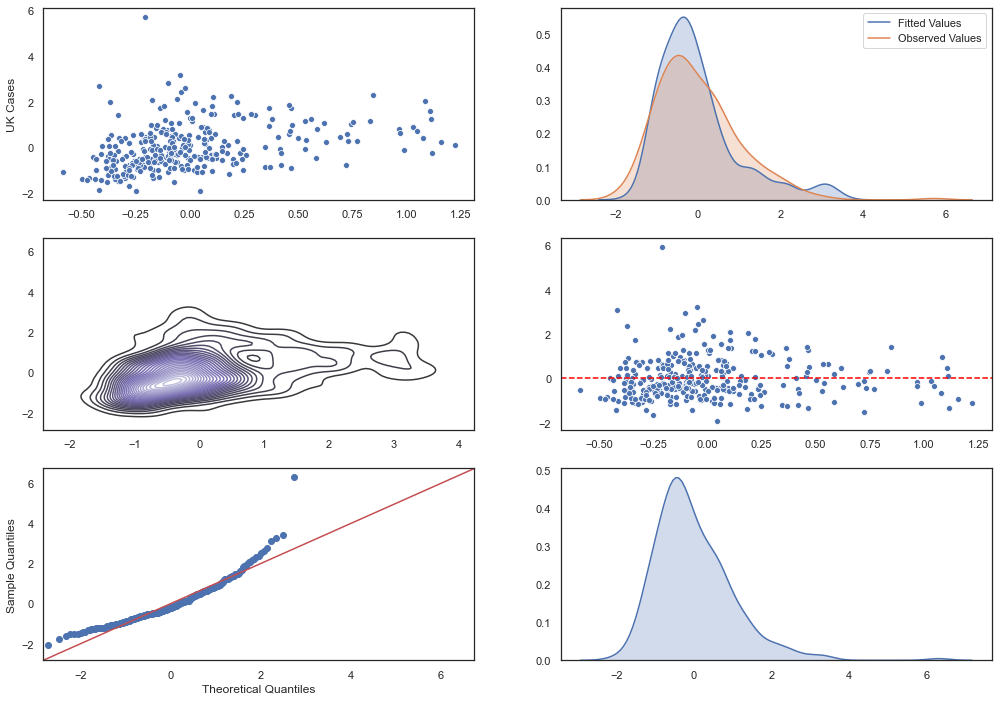

In [100]:
fig, ax = plt.subplots(3, 2, figsize=(17,12))
axes = ax.flat
sns.scatterplot(res.fittedvalues, y, ax=axes[0])
sns.kdeplot(preprocessing.scale(res.fittedvalues), label = "Fitted Values", shade=True, ax=axes[1])
sns.kdeplot(preprocessing.scale(y), label = "Observed Values", shade=True, ax=axes[1])
sns.kdeplot(preprocessing.scale(res.fittedvalues), preprocessing.scale(y), 
            n_levels=30, cmap="Purples_d", ax=axes[2])
sns.scatterplot(x=res.fittedvalues, y=res.resid, ax=axes[3])
axes[3].axhline(0, ls='--', color="red")
sm.qqplot(preprocessing.scale(res.resid), line ='45', ax=axes[4]) 
sns.kdeplot(preprocessing.scale(res.resid), shade=True, ax=axes[5])



In [217]:
pd.DataFrame({"Variables":X_scaled.columns, "Loadings":pca.components_[0]}).sort_values(by=['Loadings'], ascending=False)

,Variables,Loadings
20,Age 25 to 29,0.110176
47,Mixed/multiple ethnic groups,0.105058
53,Other Passports,0.104676
5,Density (number of persons per hectare),0.104110
34,Single (never married or never registered a sa...,0.103003
...,...,...
40,Living in a couple,-0.107175
29,Median Age,-0.107834
178,SP,-0.108794
23,Age 60 to 64,-0.110320


### kernel Principal Component Analysis

An extension of the PCA can be found on the kernel PCA.  Max Welling ([Welling, 2015](https://www.ics.uci.edu/~welling/classnotes/papers_class/Kernel-PCA.pdf)) describes the process in detail at his lecture notes. 

Kernel PCA has been built in order to address a draw back that PCA has, which is that it cannot be used on non-linear datasets; it cannot create PCs from non-linear data. Consequently, a way to remedy is to project the data $X$ from a $p$ dimensional space into a feature $m$-dimensional space $\phi$ using kernel methods ($m>p$).

Before, we venture into running a kernel-PCA model, it would be efficient and good practice to validate that indeed the variables in our dataset have non-linear relationships. Because, if they do not then we project the data into another transformed space where we loose interpretability (they do not have pre-images to the original data $X$ as the linear PCA has). Running a pairplot in $p=200$ variables is computationally and visually inneficient. A quick and handy solution is to generate a correlation matrix but instead of Pearson's $p$ to use a non-parametric, ranked, alternative like Kendall or Spearman. 



[[]]

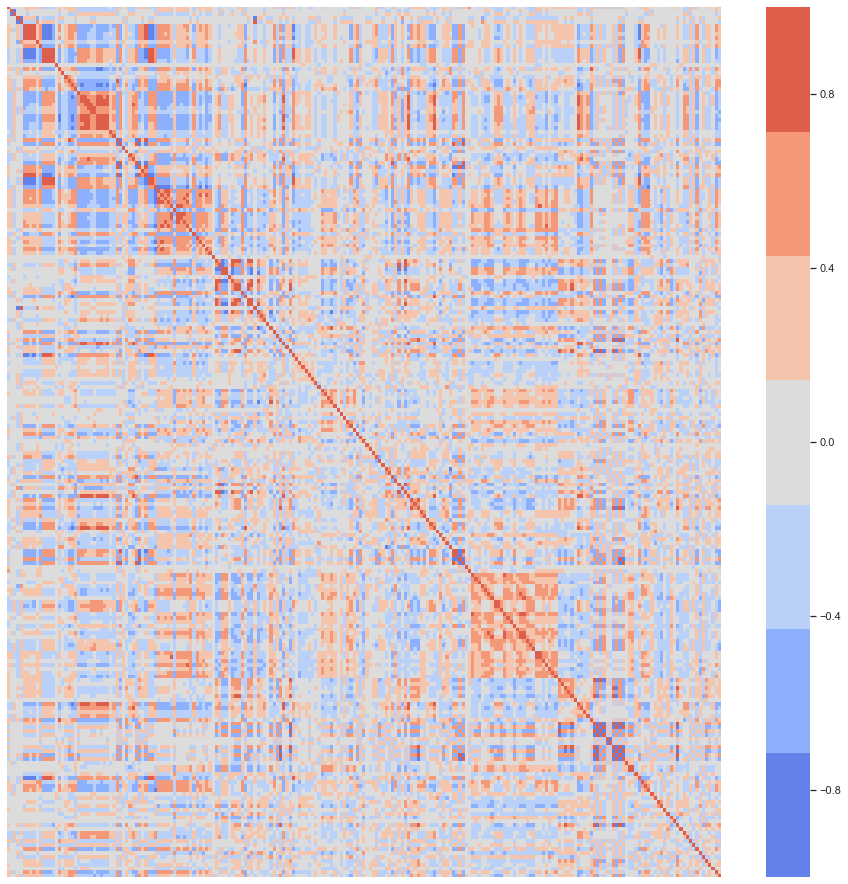

In [93]:
corr = X_scaled.corr(method='kendall')

pal = sns.color_palette("coolwarm", 7)
plt.figure(figsize=(16, 16))
g = sns.heatmap(corr, cmap=pal)
g.set(yticklabels=())
g.set(xticklabels=())

*(Figure 4)* Kendall, did not identify any new clusters in the correlation matrix. With some uncertainty we can conclude that the dataset does not suffer from non-linearity amongst the variables. 

Nevertheless, we will explore the kernel-PCA results.

As we mentioned before, PCA is based on the utilisation of eigenvectors and eigenvalues. In an eigenvector decomposition of the symmetric covariance matrix $X^{T}X$ with rank $r$ and shape $m \times m$ we have a set of orthonormal eigenvectors $\hat{v}$ of size $(m\times 1)$ and eigenvalues $\lambda$ of the size $r$. 

$$
\lambda_{i}\hat{v}_{i} = (X^{T}X)\hat{v}_{i} = \frac{1}{N}\sum_{n}x_{i}x_{i}^{}\hat{v}_{i} = \frac{1}{N}\sum_{n}x_{i}x_{i}^{T}\hat{v}_{i} = \frac{1}{N}\sum_{n}(x_{i}^{T}\hat{v}_{i})x_{i}
$$

with $i$ as the index for $r$. In turn, if we solve over $\hat{v}_{i}$

$$
\hat{v}_{i} = \sum_{n}\frac{x_{i}x_{i}^{}\hat{v}_{i}}{\lambda_{i}N} = \sum_{n}\alpha_{i}x_{i}
$$

which shows what we know already about PCA and eigendecomposition. That an eigenvector $\hat{v}_{i}$ can be re-written as a linear combination of the data. So, for a new data $x_{i}^{'}$ its projection into the linear space will be

$$
\hat{v}_{i}^{T}x_{i}^{'} = \sum_{n}\alpha_{i}K(x_{i}, x_{i}^{'})
$$

where $K$ can be interpreted as a kernel function. 

$$
\sum_{n}\alpha_{i}\phi(x_{i}) \phi(x_{i}^{'})^{T}
$$

and the final form if we substitute to the first eigendecomposition formula with the kernel transform we get

$$
K\alpha_{i} = \alpha_{i}NK
$$

Therefore, by projecting the data $x$ into a higher dimensional space ($m$) using a kernel function $\phi$ we can then decompose the new data using eigendecomposition or SVD methods without having to work directly on that feature space

The non-trivial part in kernel-PCA is to centre the data. For more details on this process Max Welling ([Welling, 2015](https://www.ics.uci.edu/~welling/classnotes/papers_class/Kernel-PCA.pdf)) offers an excellent overview.

Another important element of research in kernel-PCA and in kernel models in general is to construct/use the right kernel. Cross validation methods is a pretty much standard technique.

As an example, David Duvenaud ([Duvenaud, 2014](https://www.cs.toronto.edu/~duvenaud/cookbook/)) in his thesis presents a kernel "cookbook" where we can explore the options we have. 

For the hyperparameter optimisation in the kernelPCA we follow the method from ([Ashad Alam et al., 2014](https://thescipub.com/abstract/10.3844/jcssp.2014.1139.1150)). The authors utilise the RMSE form of the kernelPCA and they perform a CV method on the pre-images of the scores.

In [ ]:
from sklearn.model_selection import GridSearchCV

def my_scorer(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)

param_grid = [{
        "gamma": np.linspace(0.03, 0.05, 10), #Kernel coefficient for rbf, poly and sigmoid kernels. Ignored by other kernels.
        "kernel": ["rbf", "sigmoid", "poly"], 
        "degree": [3, 4, 5] #Degree for poly kernels. Ignored by other kernels.
    }]

kpca=KernelPCA(fit_inverse_transform=True, n_jobs=-1) 
grid_search = GridSearchCV(kpca, param_grid, cv=10, scoring=my_scorer)
grid_search.fit(X_scaled)

In [151]:
print(grid_search.best_params_)

{'degree': 3, 'gamma': 0.05, 'kernel': 'rbf'}


In [152]:
from sklearn.metrics import mean_squared_error
kpca = KernelPCA(kernel="rbf", degree=3, fit_inverse_transform=True, gamma=0.05, n_components=3)
X_kpca = kpca.fit_transform(X_scaled)
X_kpca = kpca.inverse_transform(X_kpca)

In [153]:
mod = sm.OLS(y, X_kpca[:,0])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:               UK Cases   R-squared (uncentered):                   0.055
Model:                            OLS   Adj. R-squared (uncentered):              0.052
Method:                 Least Squares   F-statistic:                              17.95
Date:                Thu, 28 May 2020   Prob (F-statistic):                    2.99e-05
Time:                        14:30:05   Log-Likelihood:                         -429.70
No. Observations:                 309   AIC:                                      861.4
Df Residuals:                     308   BIC:                                      865.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

*(Table 3)* The kernel PCA used in OLS regression returns significant $p-value < .0$ with a positive coefficient $\beta = 0.23$ and a very low $R^{2}=0.05$. 

But, because of its reliance on kernels the kernel PCA parameters should be optimised using CV or another efficient method. 
A more in depth research on the right kernel can also improve the results of the model. 

Again, we refer as a starting point to David Duvenaud's thesis ([Duvenaud, 2014](https://www.cs.toronto.edu/~duvenaud/cookbook/)).

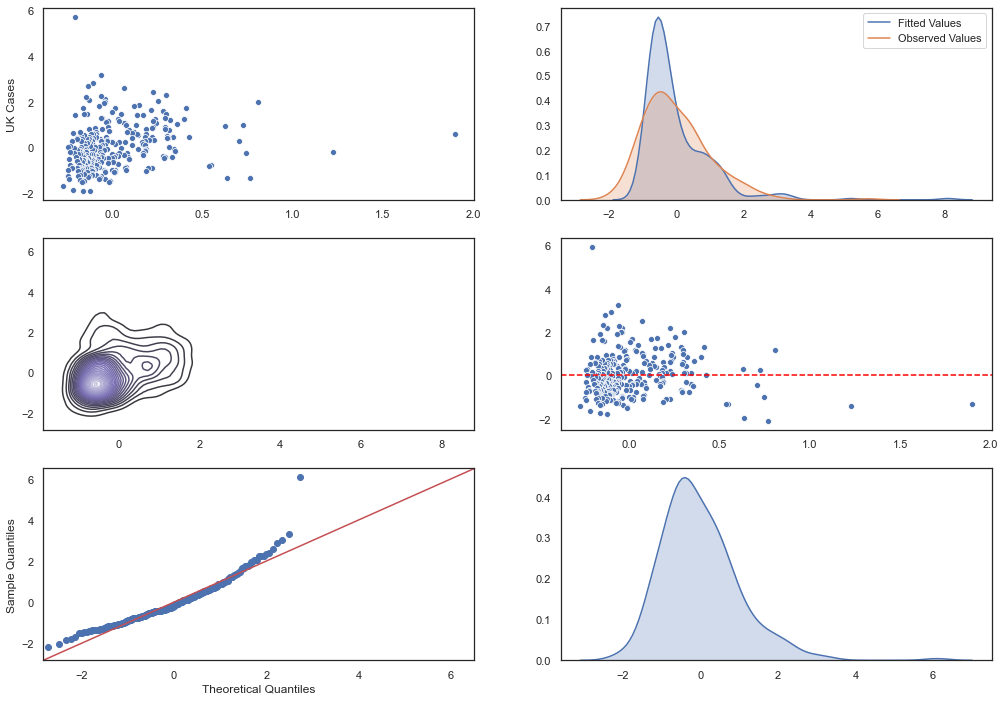

In [154]:
fig, ax = plt.subplots(3, 2, figsize=(17,12))
axes = ax.flat
sns.scatterplot(res.fittedvalues, y, ax=axes[0])
sns.kdeplot(preprocessing.scale(res.fittedvalues), label = "Fitted Values", shade=True, ax=axes[1])
sns.kdeplot(preprocessing.scale(y), label = "Observed Values", shade=True, ax=axes[1])
sns.kdeplot(preprocessing.scale(res.fittedvalues), preprocessing.scale(y), 
            n_levels=30, cmap="Purples_d", ax=axes[2])
sns.scatterplot(x=res.fittedvalues, y=res.resid, ax=axes[3])
axes[3].axhline(0, ls='--', color="red")
sm.qqplot(preprocessing.scale(res.resid), line ='45', ax=axes[4]) 
sns.kdeplot(preprocessing.scale(res.resid), shade=True, ax=axes[5])



### Sparse Principal Component Analysis

Lastly, the third PCA method that we use is the sparse PCA ([Zou et al., 2006](https://web.stanford.edu/~hastie/Papers/spc_jcgs.pdf)). The idea behind the sparse PCA is that since PCA is in fact a linear transformation of variables $X$ to new variables $Z$ we can re-write the decomposition in OLS terms and then add an L1 penalty term (LASSO). 

With this model Zou and Hastie wanted to improve the interpretability of the PCA loadings. As we mentioned, the SVD decomposition of a data matrix $X \in \mathbb{R}^{n \times p}$ has the form

$$
X = U\Sigma V^{T}
$$

where, $U$ the orthogonal matrix of eigenvectors of size $n \times n$ that rotates the data, $\Sigma$ a diagonal matrix $n \times p$ that contains the eigenvalues that stretch the data, and $V$ the orthogonal matrix $p \times p$ that again rotates the data. 

The new transformed data $Z$ can be then obtained by

$$
Z = XV
$$

The LASSO form is the standard OLS but penalised by a term $\lambda$. So, to find the coefficients of LASSO we need to optimise the 

$$
\hat{\beta} = argmin_{\beta}|| Z - XB ||^{2} + \lambda \sum_{i}^{p} |\beta|
$$

to link this formula to PCA we go back to the SVD and we modify the formula a bit

$$
X = U\Sigma V^{T} = (X^{T}X)B
$$

and we set $A=UV^{T}$ so to be the orthogonal product of eigenvectors. From [Zou et al., 2006](https://web.stanford.edu/~hastie/Papers/spc_jcgs.pdf) theorem we get

$$
(\hat{B}, \hat{A}) = argmin_{(A, B)}|| X - AB^{T}X ||^{2} + \lambda \sum_{i}^{p} |\beta|
$$

then, through a step-iterative process we optimise $B$, we perform SVD, and then we optimise $A$.

In [104]:
spca = SparsePCA(n_components=3, random_state=0, alpha=15)
X_spca = spca.fit_transform(X_scaled)

In [105]:
spca.components_[0][spca.components_[0]!=0].shape

(17,)

After some iterations we chose a penalty term of $\alpha=15$ in order to return PC as a linear combination of 17 variables.

*(Table 4)* The variables that the sparse PCA returns indeed seem sensible considering the black box nature of the algorithm. It could potentially be used as a score for the force of infection ($\lambda$) in [Gareth et al., 2011](https://arxiv.org/abs/1108.3137v1). 

Variables such as mean age, state pension (SP), older age, retired, deaths explain the variance of the dataset. Comparing to *(Table 1)* we observe that variables that contain extremes do not affect the sparse PCA results.

In [215]:
pd.DataFrame({"Variables":X_scaled.iloc[:, spca.components_[0]!=0].columns, "Loadings":spca.components_[0][spca.components_[0]!=0]}).sort_values(by=['Loadings'], ascending=False)

,Variables,Loadings
6,Mean Age,2.416122
15,SP,2.365032
3,Age 65 to 74,2.353657
13,All aged 65 and over,2.236855
7,Median Age,2.136050
12,Economically inactive: Retired,1.940103
14,Owned: Owned outright,1.937769
4,Age 75 to 84,1.914770
2,Age 60 to 64,1.887641
8,Urban Mean Age,1.476404


In [112]:
mod = sm.OLS(y, X_spca[:,0])
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:               UK Cases   R-squared (uncentered):                   0.107
Model:                            OLS   Adj. R-squared (uncentered):              0.104
Method:                 Least Squares   F-statistic:                              37.06
Date:                Thu, 28 May 2020   Prob (F-statistic):                    3.41e-09
Time:                        13:44:41   Log-Likelihood:                         -420.90
No. Observations:                 309   AIC:                                      843.8
Df Residuals:                     308   BIC:                                      847.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

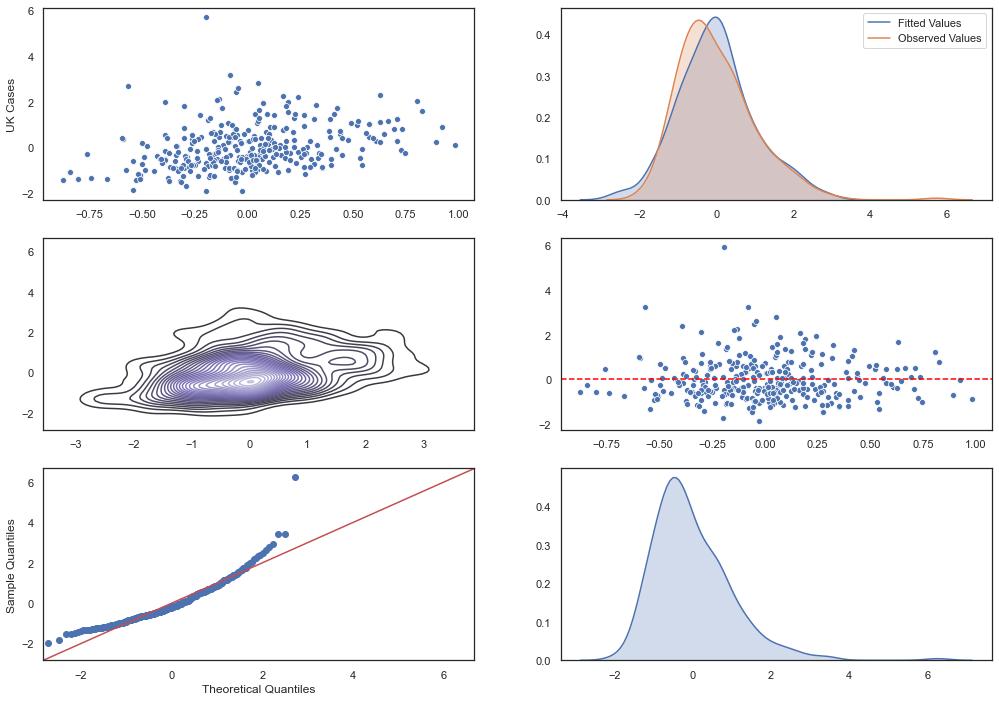

In [107]:
fig, ax = plt.subplots(3, 2, figsize=(17,12))
axes = ax.flat
sns.scatterplot(res.fittedvalues, y, ax=axes[0])
sns.kdeplot(preprocessing.scale(res.fittedvalues), label = "Fitted Values", shade=True, ax=axes[1])
sns.kdeplot(preprocessing.scale(y), label = "Observed Values", shade=True, ax=axes[1])
sns.kdeplot(preprocessing.scale(res.fittedvalues), preprocessing.scale(y), 
            n_levels=30, cmap="Purples_d", ax=axes[2])
sns.scatterplot(x=res.fittedvalues, y=res.resid, ax=axes[3])
axes[3].axhline(0, ls='--', color="red")
sm.qqplot(preprocessing.scale(res.resid), line ='45', ax=axes[4]) 
sns.kdeplot(preprocessing.scale(res.resid), shade=True, ax=axes[5])



### LASSO

A final step is to use LASSO directly on the data.

In [193]:
model = LassoCV(cv=10, max_iter = 100000).fit(X_scaled, y)

In [194]:
EPSILON = 1e-4
m_log_alphas = -np.log10(model.alphas_ + EPSILON)

(0, 3)

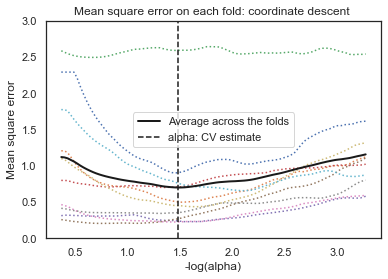

In [195]:


plt.figure()
ymin, ymax = 0, 3
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_ + EPSILON), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ')
plt.axis('tight')
plt.ylim(ymin, ymax)

*(Table 5)* LASSO has selected 35 out of the 222 variables as the most important in explaining the COVID-19 deaths in LADs. 

The results show that religious people contribute in the spread of COVID-19 in an area, probable cause is that they gather in closed spaces. Households with no usual residents also is an important factor in the spread of the virus. People who work in the health services contribute in explaining the spread as well as people who commute using public transport. IB/SDA are people who have sever disability and health conditions and claim thhe relevant benefits. The Persona 7 is an OAC supergroup that has a lower proportion of people aged 5 to 14 and a higher level aged 65 and over than nationally. It is more densely populated than the UK average. People are more likely to be single or divorced. There is a lower representation of all the non-White ethnic groups and of people who were born in other EU countries. There is a lower proportion of households with no children. Households are more likely to live in flats and to live in social rented accommodation, and there is a higher prevalence of overcrowding. There is a higher proportion of people whose day-to-day activities are limited, and lower qualification levels than nationally. There is a higher level of unemployment in the supergroup. There are no particular industries in which workers are most likely to be employed, but some industries such as information and communication, and the education sector are underrepresented.

In [201]:
pd.DataFrame({"Variables":X_scaled.columns[model.coef_!=0], "Coeff":np.round(model.coef_[model.coef_!=0], 4)}).sort_values(by=['Coeff'], ascending=False)

,Variables,Coeff
4,Christian,0.1864
32,Persona 7,0.1583
5,Buddhist,0.1469
17,Household spaces with no usual residents,0.1257
13,Q Human health and social work activities,0.1190
25,JSA,0.0851
29,Median Income,0.0786
24,IB/SDA,0.0752
10,"D Electricity, gas, steam and air conditioning...",0.0712
14,"Bus, minibus or coach",0.0695


In [237]:
model.coef_[model.coef_!=0].shape

(35,)